In [12]:
import acoular
import matplotlib.pyplot as pl
import ipywidgets as ipw
import numpy as np
from glob import glob
from os import path
import pylab as plt
import math as m
import mpl_toolkits.mplot3d
import scipy as sc


In [13]:
#Einlesen der Micgeo
micgeofile = 'mic_geo.xml'
mg = acoular.MicGeom(from_file=micgeofile)
mg.mpos[0] = - mg.mpos[0] #Spiegeln
mg.mpos[0] = mg.mpos[0] + 0.419 #Versatz
#print(mg.mpos)

#Rotationsmatrix
def Rx(theta):
  return np.matrix([[ 1, 0           , 0           ],
                   [ 0, m.cos(theta),-m.sin(theta)],
                   [ 0, m.sin(theta), m.cos(theta)]])

for i in range (64):
    Punkt = [mg.mpos[0][i],mg.mpos[1][i],mg.mpos[2][i]]
    rot = np.array(Punkt * Rx(np.radians(-45)))
    #print(rot[0][0])
    mg.mpos[0][i] = rot[0][0]
    mg.mpos[1][i] = rot[0][1]
    mg.mpos[2][i] = rot[0][2]
mg.mpos[1] = - mg.mpos[1]

#plt.ion()
#plt.plot(mg.mpos[2],mg.mpos[1],'o')

# Umgebung definieren (Medium, Strömung etc)
t = 23.6
e = acoular.Environment(c = 20.05*np.sqrt(273+t))

Einlesen der Daten:

In [14]:
#Simuliertes Signal erzeugen
sfreq = 51200
duration = 1
nsamples = duration*sfreq

sim_signal1 = acoular.WNoiseGenerator(sample_freq=sfreq, numsamples=nsamples, seed=1)
sim_signal2 = acoular.WNoiseGenerator(sample_freq=sfreq, numsamples=nsamples, seed=2)

sim_signal = acoular.SineGenerator(sample_freq = sfreq,   # Abtastfrequenz
                     numsamples = nsamples,     # Anzahl der Samples, entspricht Messzeit (hier extrem kurz)
                     freq = 800,           # Sinusfrequenz
                     amplitude = 1.)     

sim_ts1 = acoular.PointSource(signal = sim_signal1,          # Signal der Quelle
                   loc = (1.5, 0.2, 2.0),  # Position der Punktquelle im links-orientierten Koordinatensystem
                   mics = mg,            # Mikrofongeometrie, auf der Messdaten erzeugt werden sollen
                   env = e)             # Umgebung, in der sich das Schallfeld ausbreitet
sim_ts2 = acoular.PointSource(signal = sim_signal2,          # Signal der Quelle
                   loc = (-1.0, 0.2, 1.6),  # Position der Punktquelle im links-orientierten Koordinatensystem
                   mics = mg,            # Mikrofongeometrie, auf der Messdaten erzeugt werden sollen
                   env = e)             # Umgebung, in der sich das Schallfeld ausbreitet
ts = acoular.SourceMixer( sources=[sim_ts1,sim_ts2])
'''
sim_signal1 = acoular.WNoiseGenerator(sample_freq=sfreq, numsamples=nsamples, seed=1)

ts = acoular.PointSource(signal = sim_signal1,          # Signal der Quelle
                   loc = (0, 0.2, 10.0),  # Position der Punktquelle im links-orientierten Koordinatensystem
                   mics = mg,            # Mikrofongeometrie, auf der Messdaten erzeugt werden sollen
                   env = e)             # Umgebung, in der sich das Schallfeld ausbreitet
'''

'\nsim_signal1 = acoular.WNoiseGenerator(sample_freq=sfreq, numsamples=nsamples, seed=1)\n\nts = acoular.PointSource(signal = sim_signal1,          # Signal der Quelle\n                   loc = (0, 0.2, 10.0),  # Position der Punktquelle im links-orientierten Koordinatensystem\n                   mics = mg,            # Mikrofongeometrie, auf der Messdaten erzeugt werden sollen\n                   env = e)             # Umgebung, in der sich das Schallfeld ausbreitet\n'

In [79]:
#Einlesen der Daten:
#ts = acoular.TimeSamples( name='Messungen WFS\msm_025.h5' )
ts = acoular.TimeSamples( name='Messungen WFS/msm_025.h5' )
ts 

In [80]:

#Grid erstellen
rg = acoular.RectGrid3D(x_min=-5, x_max=5, 
                       y_min=-2, y_max=2, 
                       z_min=2, z_max=2, 
                       increment=0.05)

#Steering Vector
st = acoular.SteeringVector( grid=rg, 
                             mics=mg, 
                             #ref=1,     # Tipp von Gert, ref auf 1m, stimmt das so? Und wieso?
                             env = e,
                             steer_type = 'true location') # ???

#Spectrum erstellen:
ps = acoular.PowerSpectra( time_data=ts, 
                           block_size=512,
                           freq_range=[1000, 2500],
                           window='Hanning' ) # Für bessere Auflösung hier Block_size erhöhen -> höherer Rechnenaufwand, daher jetzt erstmal mit 128


bb = acoular.BeamformerBase( freq_data=ps, 
                             steer=st )

                             #Grid erstellen
rg2 = acoular.RectGrid3D(x_min=-5, x_max=5, 
                       y_min=0.13, y_max=0.13, 
                       z_min=0, z_max=5, 
                       increment=0.05)

#Steering Vector
st2 = acoular.SteeringVector(grid=rg2, 
                             mics=mg, 
                             #ref=1,     # Tipp von Gert, ref auf 1m, stimmt das so? Und wieso?
                             env = e,
                             steer_type = 'true location') # ???

#Spectrum erstellen:
ps2 = acoular.PowerSpectra(time_data=ts, 
                           block_size=512,
                           freq_range=[1000, 2500],
                           window='Hanning' ) # Für bessere Auflösung hier Block_size erhöhen -> höherer Rechnenaufwand, daher jetzt erstmal mit 128


bb2 = acoular.BeamformerBase(freq_data=ps2, 
                             steer=st2 )



In [81]:
#ps.fftfreq()

In [82]:
# 500 1000 2000
# 500 630 800 1000 1250 1600 2000 2500 3150 4000 5000 6300 8000 10000 12500 16000 20000

Frequenz = 1000
tolerance = 10
pm = bb.synthetic(Frequenz, 0)
pm2 = bb2.synthetic(Frequenz, 0)
 # 0=Freq, 1=Okt, 3=Terz
#Lm = acoular.L_p( pm )
#Lm = (Lm[0:],Lm[1:])

[('msm_025_cache.h5', 1)]
[('msm_025_cache.h5', 2)]
[('msm_025_cache.h5', 3)]
[('msm_025_cache.h5', 4)]


Quellposition xy bei x = [-0.05] / y = [0.25]
Quellposition xz bei x = [-0.05] / z = [1.6]


Text(0.5, 1.0, 'Side view (xz)')

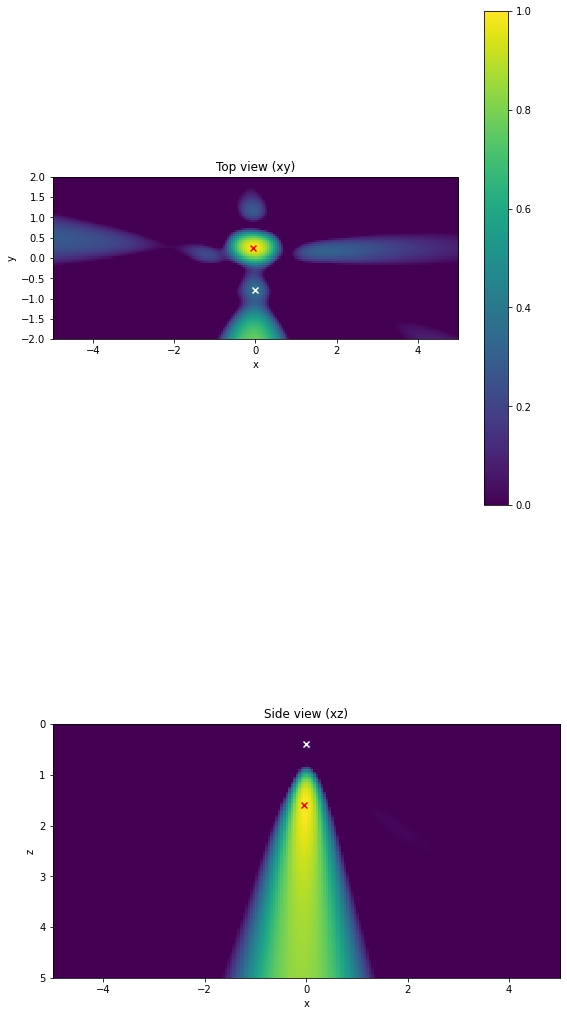

In [83]:
fig=plt.figure(1,(20,20))

# plot the results

plt.subplot(221)
map_z = np.sum(pm,2)
mx = acoular.L_p(map_z.max())
Lm_z = acoular.L_p(map_z)
Lm_z_rot = np.rot90(Lm_z)#rotiert Lm um 90 Grad

Lm_z_max = sc.signal.argrelmax(Lm_z)
Lm_z_rot_max = sc.signal.argrelmax(Lm_z_rot)


max_values_z = []
for i in range (len(Lm_z_max[0])):
    max_value_z = Lm_z[Lm_z_max[0][i]][Lm_z_max[1][i]]

    if (max_value_z >= np.amax(Lm_z.T) - tolerance):
        max_values_z.append(max_value_z)
max_values_z = np.array(max_values_z)

max_values_rot_z = []
for i in range (len(Lm_z_rot_max[0])):
    max_value_rot_z  = Lm_z_rot[Lm_z_rot_max[0][i]][Lm_z_rot_max[1][i]]

    if (max_value_rot_z  >= np.amax(Lm_z.T) - tolerance):
        max_values_rot_z .append(max_value_rot_z)
max_values_rot_z  = np.array(max_values_rot_z)

max_pegel_z  = []
for i in range (len(max_values_z)):
    
    if (max_values_z [i] in max_values_rot_z):
        max_pegel_z .append(max_values_z[i])
max_pegel_z  = np.sort(max_pegel_z)      
max_pegel_z  = max_pegel_z[::-1]
plt.imshow(acoular.L_p(map_z.T), vmax=mx, vmin=mx-15, origin='lower', interpolation='nearest', 
       extent=(rg.x_min, rg.x_max, rg.y_min, rg.y_max))
plt.scatter(np.where(Lm_z.T == max_pegel_z[0])[1]*rg.increment-((rg.x_max-rg.x_min)/2),np.where(Lm_z.T == max_pegel_z[0])[0]*rg.increment-((rg.y_max-rg.y_min)/2),  c='red',  marker = 'x')
print(f'Quellposition xy bei x = {np.where(Lm_z.T == max_pegel_z[0])[1]*rg.increment-((rg.x_max-rg.x_min)/2)} / y = {np.where(Lm_z.T == max_pegel_z[0])[0]*rg.increment-((rg.y_max-rg.y_min)/2)}')
for i in range(1,len(max_pegel_z)):
    plt.scatter(np.where(Lm_z.T == max_pegel_z[i])[1]*rg.increment-((rg.x_max-rg.x_min)/2),np.where(Lm_z.T == max_pegel_z[i])[0]*rg.increment-((rg.y_max-rg.y_min)/2),  c='white',  marker = 'x')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Top view (xy)' )
plt.colorbar()

plt.subplot(223)
map_y = np.sum(pm2,1)
if (rg2.y_min == rg2.y_max):
       mx = acoular.L_p(map_y.max())
Lm_y = acoular.L_p(map_y)
Lm_y_rot = np.rot90(Lm_y)#rotiert Lm um 90 Grad

Lm_y_max = sc.signal.argrelmax(Lm_y)
Lm_y_rot_max = sc.signal.argrelmax(Lm_y_rot)


max_values_y = []
for i in range (len(Lm_y_max[0])):
    max_value_y = Lm_y[Lm_y_max[0][i]][Lm_y_max[1][i]]

    if (max_value_y >= np.amax(Lm_y.T) - tolerance):
        max_values_y.append(max_value_y)
max_values_y = np.array(max_values_y)

max_values_rot_y = []
for i in range(len(Lm_y_rot_max[0])):
    max_value_rot_y = Lm_y_rot[Lm_y_rot_max[0][i]][Lm_y_rot_max[1][i]]

    if (max_value_rot_y >= np.amax(Lm_y.T) - tolerance):
        max_values_rot_y .append(max_value_rot_y)
max_values_rot_y = np.array(max_values_rot_y)

max_pegel_y = []
for i in range(len(max_values_y)):

    if (max_values_y[i] in max_values_rot_y):
        max_pegel_y .append(max_values_y[i])
max_pegel_y = np.sort(max_pegel_y)
max_pegel_y = max_pegel_y[::-1]
plt.imshow(acoular.L_p(map_y.T), vmax=mx, vmin=mx-10, origin='upper', interpolation='nearest', 
       extent=(rg2.x_min, rg2.x_max, rg2.z_max, rg2.z_min))
plt.scatter(np.where(Lm_y.T == max_pegel_y[0])[1]*rg.increment-((rg.x_max-rg.x_min)/2),np.where(Lm_y.T == max_pegel_y[0])[0]*rg.increment,  c='red',  marker = 'x')
print(f'Quellposition xz bei x = {np.where(Lm_y.T == max_pegel_y[0])[1]*rg.increment-((rg.x_max-rg.x_min)/2)} / z = {np.where(Lm_y.T == max_pegel_y[0])[0]*rg.increment}')
for i in range(1,len(max_pegel_z)):
    plt.scatter(np.where(Lm_y.T == max_pegel_y[i])[1]*rg.increment-((rg.x_max-rg.x_min)/2),np.where(Lm_y.T == max_pegel_y[i])[0]*rg.increment,  c='white',  marker = 'x')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Side view (xz)' )


